In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gd_traj(x0, p0, h, Ns, Pars, Model):
    T = [0]  # Time steps
    X = [x0]  # Positions
    P = [p0]  # Momentum/Velocity
    KE = [np.dot(p0, p0)]  # Kinetic energy
    PE = [Model['U'](x0, Pars)]  # Potential energy

    x = np.array(x0)
    v = np.zeros_like(p0)  # Velocity initialized to zero
    t = 0

    for _ in range(Ns):
        x, v = gd_step_with_momentum(x, v, h, Pars, Model)
        t += h
        T.append(t)
        X.append(x)
        P.append(v)  # Store velocity as "momentum"
        KE.append(np.dot(v, v))  # Kinetic energy is based on velocity
        PE.append(Model['U'](x, Pars))

    return np.array(T), np.array(X), np.array(P), np.array(KE), np.array(PE)


def gd_step_with_momentum(x, v, h, Pars, Model):
    grad_U = -Model['F'](x, Pars)  # Force is the negative gradient
    v = Pars['beta'] * v - h * grad_U  # Update velocity with momentum
    x = x + v  # Update position
    return x, v

def gd_step(x, p, t, h, Pars, Model):
    return x + h * Model['F'](x, Pars), p

def kd_traj(x0, p0, h, Ns, Pars, Model, tol = 1e-8):
    T = [0]
    X = [x0]
    P = [p0]
    KE = [np.dot(p0, p0)]
    PE = [Model['U'](x0, Pars)]
    x = np.array(x0)
    p = np.array(p0)
    t = 0

    for _ in range(Ns):
        x, p = kd_step(x, p, t, h, Pars, Model, tol = tol)
        t += h
        T.append(t)
        X.append(x)
        P.append(p)
        KE.append(np.dot(p, p))
        PE.append(Model['U'](x, Pars))

    return np.array(T), np.array(X), np.array(P), np.array(KE), np.array(PE)

def U_step(x0, p0, t0, h, Pars):
    c0 = Pars['decay']['c'](t0, Pars)
    #csqrt = lambda t: Pars['decay']['csqrt'](t, Pars)
    analytical = 2 * (1 - np.exp(-0.5 * Pars['gamma'] * h)) * p0 / Pars['gamma']
    x1 = x0 + analytical#(2 * p0 / np.sqrt(c0)) * simp(csqrt, t0, t0 + h, 16)
    p1 = p0 * np.sqrt(Pars['decay']['c'](t0 + h, Pars) / c0)
    return x1, p1

def myrk4step(t,y,h,f):
    F0 = f(t,y)
    Y1 = y + (h/2)*F0
    F1 = f(t+h/2, Y1)
    Y2 = y + (h/2)*F1
    F2 = f(t+h/2, Y2)
    Y3 = y + h*F2
    F3 = f(t+h, Y3)
    y1 = y + (h/6)*(F0 + 2*F1 + 2*F2 + F3)
    return y1
    
def KB_step(x, p, h, Pars, Model, tol):
    c = np.dot(p, p)
    if c < tol:
        c += tol
    F = Model['F'](x, Pars)
    nF = np.linalg.norm(F)
    F_tilde, p_tilde = F/nF, p/np.sqrt(c)
    eta = np.dot(p_tilde, F_tilde)
    alpha = nF / np.sqrt(c)
    u = 1-eta
    if (u > tol):
        kappa = np.arctanh(eta)
        #print('np0: ' + str(np.sqrt(c)), 'nF: ' + str(nF), 'alpha: ' + str(alpha), 'eta: '+ str(eta), 'kappa: ' + str(kappa))
        A = np.cosh(kappa) / np.cosh(alpha * h + kappa)
        B = (np.sinh(alpha * h + kappa) - np.sinh(kappa)) / (alpha * np.cosh(alpha * h + kappa))
        #A, B = stable_AB(alpha, h, kappa)
    else:
        vf = lambda t,y: np.array([-alpha*(1 - np.exp(-2*alpha*t)*u)*y[0], 1 - alpha*(1 - np.exp(-2*alpha*t)*u)*y[1]])
        y0 = np.array([1,0])
        y1 = myrk4step(0,y0,h,vf)
        A, B = y1[0], y1[1]
    p = A * p + B * F 
    return x,p,F

def simp(f, a, b, n):
    if n % 2 == 1:
        n += 1  # Ensure n is even
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = np.array([f(xi) for xi in x])
    return h / 3 * (y[0] + 2 * np.sum(y[2:n:2]) + 4 * np.sum(y[1:n:2]) + y[n])

def kd_step(x0, p0, t0, h, Pars, Model, tol):
    x1, p1, F = KB_step(x0, p0, h, Pars, Model, tol)
    x1, p1 = U_step(x1, p1, t0, h, Pars)
    return x1, p1

def plot_diagnostics_2D(Q,P,T,U,potential_lambda,Pars,lim=3):
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    x = np.linspace(-lim, lim, 100)
    y = np.linspace(-lim, lim, 100)
    X, Y = np.meshgrid(x, y)
    Z = potential_lambda(X,Y)
    contourf = axs[0][0].contourf(X, Y, Z, levels=np.linspace(0, 9, 10), cmap='viridis', alpha=0.7)
    fig.colorbar(contourf, ax=axs[0][0], label='Potential U(q)')
    _, = axs[0][0].plot(Q[:, 0], Q[:, 1], lw=1.5, color = 'yellow')
    axs[0][0].set_xlabel('q1')
    axs[0][0].set_ylabel('q2')
    axs[0][0].set_title('Trajectory on Filled Contours of Potential Function')
    axs[0][0].grid(True)
    axs[0][1].plot(T, U)
    axs[0][1].set_xlabel('t')
    axs[0][1].set_ylabel('U(q)')
    axs[1][1].semilogy(T, np.exp(-Pars['gamma'] * T) , color = 'green', label = 'Desired KE')
    axs[1][1].semilogy(T, 0.5 * np.linalg.norm(P, axis=1)**2, label = 'KE')
    axs[1][1].set_xlabel('t')
    axs[1][1].set_ylabel('Energy')
    axs[1][0].semilogy(T, U) 
    axs[1][0].set_xlabel('Time')
    axs[1][0].set_ylabel('log U(q)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_compare(Q_gd, Q_kd, P_gd, P_kd, T, U_gd, U_kd, potential_lambda, c_0, gamma,lim=3):
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    x = np.linspace(-lim, lim, 100)
    y = np.linspace(-lim, lim, 100)
    X, Y = np.meshgrid(x, y)
    Z = potential_lambda(X,Y)
    contourf = axs[0][0].contourf(X, Y, Z, levels=np.linspace(0, 9, 10), cmap='viridis', alpha=0.7)
    fig.colorbar(contourf, ax=axs[0][0], label='Potential U(q)')
    _, = axs[0][0].plot(Q_gd[:, 0], Q_gd[:, 1], lw=1.5, color = 'blue')
    _, = axs[0][0].plot(Q_kd[:, 0], Q_kd[:, 1], lw=1.5, color = 'red')
    axs[0][0].set_xlabel('q1')
    axs[0][0].set_ylabel('q2')
    axs[0][0].set_title('Trajectory on Filled Contours of Potential Function')
    axs[0][0].grid(True)
    axs[0][1].plot(T, U_gd, label = 'GDM', color = 'blue')
    axs[0][1].plot(T, U_kd, label = 'KD', color = 'red')
    axs[0][1].set_xlabel('t')
    axs[0][1].set_ylabel('U(q)')

    axs[1][1].semilogy(T, c_0 * np.exp(-gamma * T), color = 'green', label = 'Desired KE')
    axs[1][1].semilogy(T, 0.5 * np.linalg.norm(P_gd, axis=1)**2, label = 'GDM', color = 'blue')
    axs[1][1].semilogy(T, 0.5 * np.linalg.norm(P_kd, axis=1)**2, label = 'KD', color = 'red')
    #axs[1][1].plot(T, U, label = 'PE')
    #axs[1][1].plot(T, U + 0.5 * np.linalg.norm(P, axis=1)**2, color = 'black', label = 'Hamiltonian')
    axs[1][1].set_xlabel('t')
    axs[1][1].set_ylabel('Energy')

    axs[1][0].semilogy(T, U_gd, label = 'RK4', color = 'blue')
    axs[1][0].semilogy(T, U_kd, label = 'RED', color = 'red')
    axs[1][0].set_xlabel('Time')
    axs[1][0].set_ylabel('log U(q)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Quadratic Potential

In [2]:
def gd_traj(x0, p0, h, Ns, Pars, Model, beta=0.9):
    T = [0]  # Time steps
    X = [x0]  # Positions
    P = [p0]  # Momentum/Velocity
    KE = [np.dot(p0, p0)]  # Kinetic energy
    PE = [Model['U'](x0, Pars)]  # Potential energy

    x = np.array(x0)
    v = np.zeros_like(p0)  # Velocity initialized to zero
    t = 0

    for _ in range(Ns):
        x, v = gd_step_with_momentum(x, v, h, beta, Pars, Model)
        t += h
        T.append(t)
        X.append(x)
        P.append(v)  # Store velocity as "momentum"
        KE.append(np.dot(v, v))  # Kinetic energy is based on velocity
        PE.append(Model['U'](x, Pars))

    return np.array(T), np.array(X), np.array(P), np.array(KE), np.array(PE)


def gd_step_with_momentum(x, v, h, beta, Pars, Model):
    grad_U = -Model['F'](x, Pars)  # Force is the negative gradient
    v = beta * v - h * grad_U  # Update velocity with momentum
    x = x + v  # Update position
    return x, v

def gd_step(x, p, t, h, Pars, Model):
    return x + h * Model['F'](x, Pars), p

In [5]:
Pars = {}
Model = {}
Pars['gamma'] = .1
decay_exp = {
    'c': lambda t, P: np.exp(-P['gamma'] * t), #+ 1e-12, #np.maximum(np.exp(-P['gamma'] * t), 1e-10),
    'cp': lambda t, P: -P['gamma'] * np.exp(-P['gamma'] * t), #np.where(np.exp(-P['gamma'] * t) > 1e-10, -P['gamma'] * np.exp(-P['gamma'] * t), 0.0),
    'csqrt': lambda t, P: np.sqrt(np.exp(-P['gamma'] * t))# + 1e-12) #np.sqrt(np.maximum(np.exp(-P['gamma'] * t), 1e-10))
}
Pars['decay'] = decay_exp

U_quad = lambda x, P: 0.5 * (x[0]**2 + x[1]**2)
F_quad = lambda x, P: -np.array([x[0], x[1]])

Model['U'] = U_quad
Model['F'] = F_quad

x0 = np.array([3., 3.])
p0 = F_quad(x0, Pars)
p0 /= np.linalg.norm(p0)
p0 *= np.sqrt(2)
h = 0.1
Ns = 1000
T, X, P, KE, PE = kd_traj(x0, p0, h, Ns, Pars, Model)

/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_21907/1189911361.py:87: RuntimeWarning: divide by zero encountered in arctanh
  kappa = np.arctanh(eta)
/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_21907/1189911361.py:89: RuntimeWarning: invalid value encountered in scalar divide
  A = np.cosh(kappa) / np.cosh(alpha * h + kappa)
/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_21907/1189911361.py:90: RuntimeWarning: invalid value encountered in scalar subtract
  B = (np.sinh(alpha * h + kappa) - np.sinh(kappa)) / (alpha * np.cosh(alpha * h + kappa))


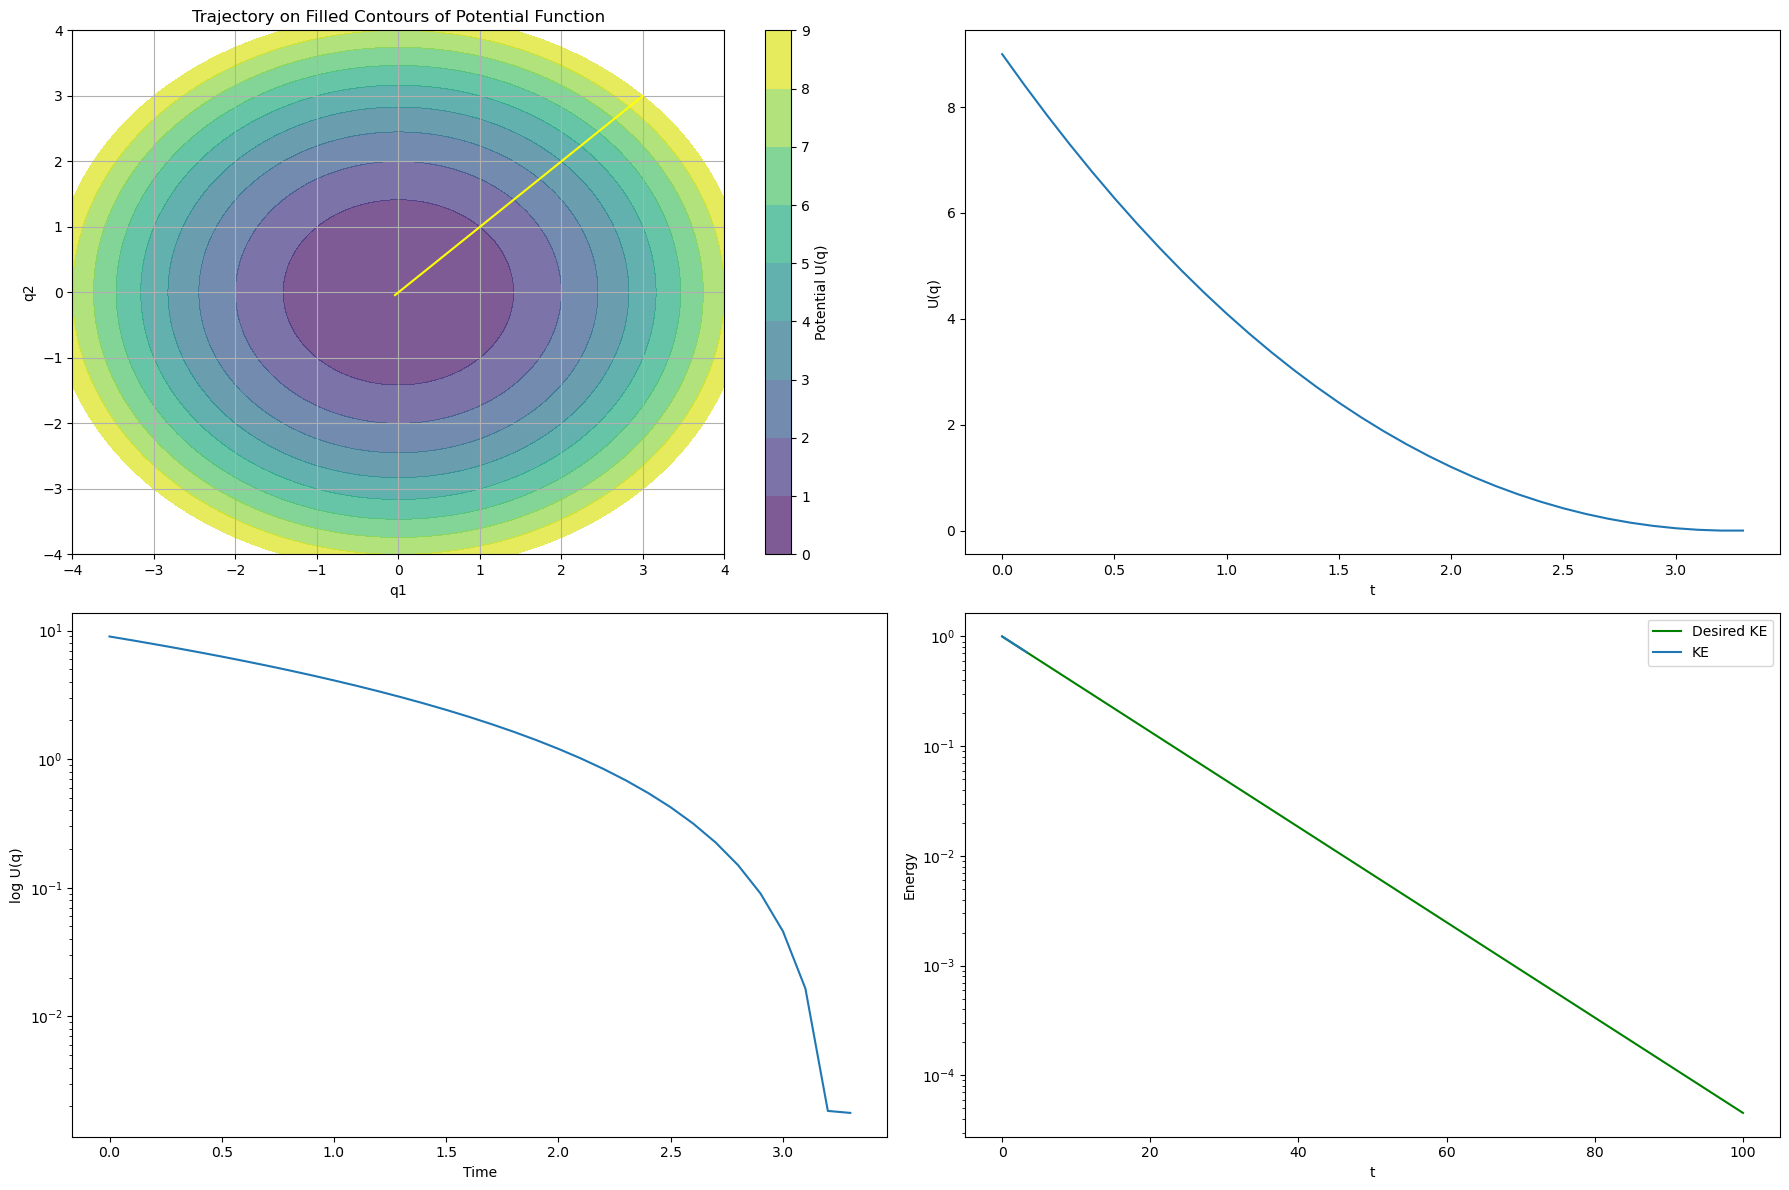

In [6]:
plot_diagnostics_2D(X,P,T,PE,lambda X,Y: 0.5 * (1 * X**2 + 1 * Y**2),Pars,lim=4)

# Rosenbrock

/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_60656/1415383209.py:82: RuntimeWarning: invalid value encountered in divide
  F_tilde, p_tilde = F/nF, p/np.sqrt(c)
/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_60656/1415383209.py:87: RuntimeWarning: divide by zero encountered in arctanh
  kappa = np.arctanh(eta)
/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_60656/1415383209.py:89: RuntimeWarning: invalid value encountered in scalar divide
  A = np.cosh(kappa) / np.cosh(alpha * h + kappa)
/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_60656/1415383209.py:90: RuntimeWarning: invalid value encountered in scalar subtract
  B = (np.sinh(alpha * h + kappa) - np.sinh(kappa)) / (alpha * np.cosh(alpha * h + kappa))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


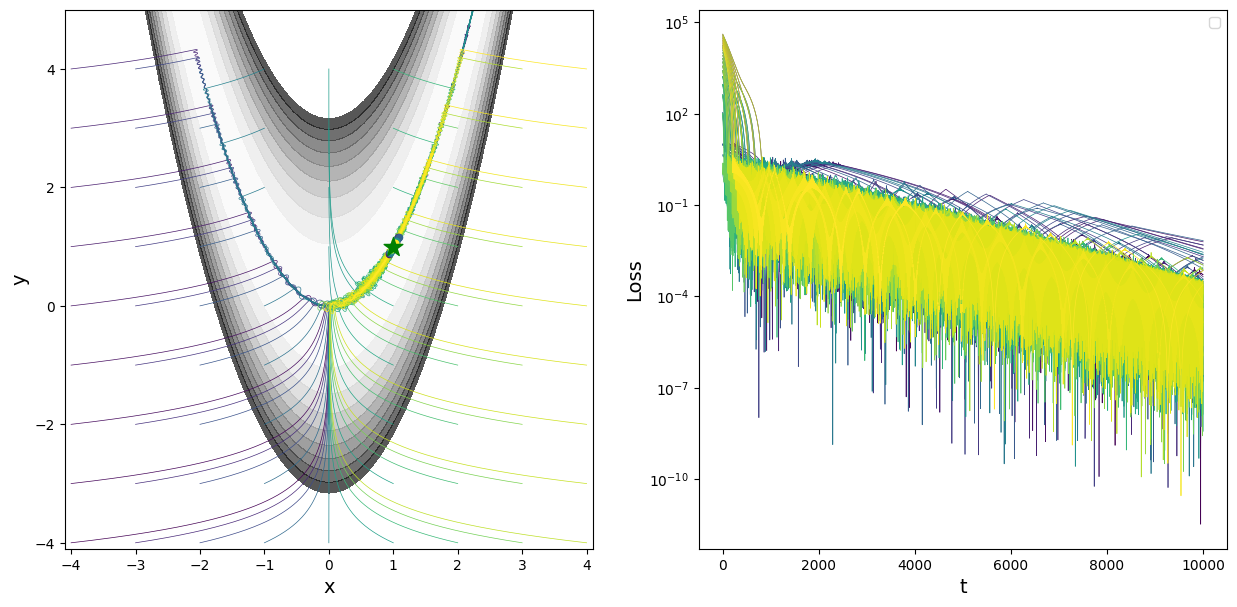

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def U_rosenbrock(x, P):
    return (P['coeff'][0] - x[0])**2 + P['coeff'][1] * (x[1] - x[0]**2)**2

def F_rosenbrock(x, P):
    return -np.array([
        -2 * (P['coeff'][0] - x[0]) - 4 * P['coeff'][1] * (x[1] - x[0]**2) * x[0],
        2 * P['coeff'][1] * (x[1] - x[0]**2)
    ]).astype(float)

# Define the parameters and setup
Pars = {
    'gamma': .1,
    'coeff': [1, 100],
    'decay': {
        'c': lambda t, P: np.exp(-P['gamma'] * t),
        'cp': lambda t, P: -P['gamma'] * np.exp(-P['gamma'] * t),
        'csqrt': lambda t, P: np.sqrt(np.exp(-P['gamma'] * t))
    }
}
Model = {'U': U_rosenbrock, 'F': F_rosenbrock}
Ns = 10000
h = 0.01

# Define the grid for contour plot
x_vals = np.linspace(-4, 5, 100)
y_vals = np.linspace(-4, 5, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.array([[U_rosenbrock([x, y], Pars) for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])

# Initialize colors for trajectories
x_grid = np.array([[i, j] for i in range(-4, 5) for j in range(-4, 5)])
num_trajectories = len(x_grid)
colors = plt.cm.viridis(np.linspace(0, 1, num_trajectories))  # Generate a unique color for each trajectory

# Plot the contour and trajectories
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].contourf(X, Y, Z, levels=np.linspace(0, 1000, 10), cmap='Greys', alpha=0.7)

for idx, x0 in enumerate(x_grid):
    color = colors[idx]
    p0 = F_rosenbrock(x0, Pars)
    p0 /= np.linalg.norm(p0) if np.linalg.norm(p0) != 0 else 1
    T, X_traj, P, KE, PE = kd_traj(x0, p0, h, Ns, Pars, Model)
    X_traj = np.array(X_traj)
    
    # Plot trajectory
    axs[0].plot(X_traj[:, 0], X_traj[:, 1], linewidth=0.5, color=color, zorder=1)
    axs[0].scatter(X_traj[-1, 0], X_traj[-1, 1], color=color, s=20, zorder=2)  # Mark trajectory ends
    axs[1].semilogy(T/h, PE, linewidth=0.5, color=color)  # Loss curve

# Final annotations and formatting
axs[0].scatter(1, 1, color='green', s=200, marker='*', label='Global Minimum', zorder=2)
axs[0].set_xlabel('x', fontsize=14)
axs[0].set_ylabel('y', fontsize=14)
axs[1].set_xlabel('t', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[0].set_xlim(-4.1, 4.1)
axs[0].set_ylim(-4.1, 5)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


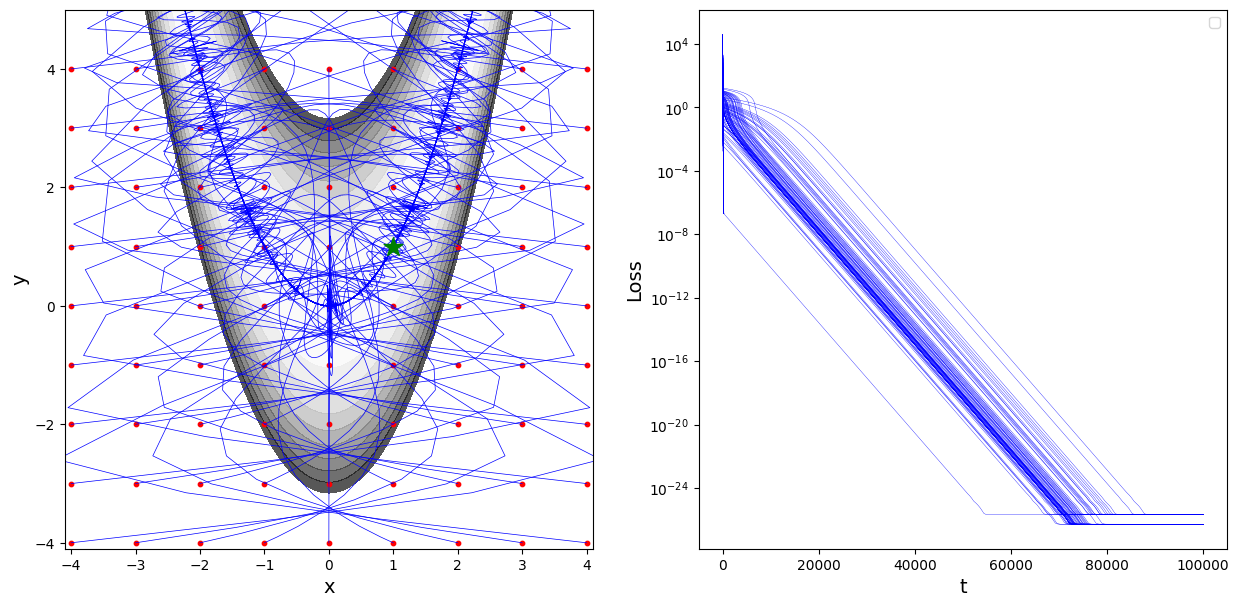

In [68]:


def U_rosenbrock(x, P):
    return (P['coeff'][0] - x[0])**2 + P['coeff'][1] * (x[1] - x[0]**2)**2

def F_rosenbrock(x, P):
    return -np.array([
        -2 * (P['coeff'][0] - x[0]) - 4 * P['coeff'][1] * (x[1] - x[0]**2) * x[0],
        2 * P['coeff'][1] * (x[1] - x[0]**2)
    ])

# Define the parameters and setup
Pars = {
    'gamma': .5,
    'coeff': [1, 100],
    'decay': {
    'c': lambda t, P: np.exp(-P['gamma'] * t), #* (np.cos(omega * t) + 2), # (10*t+1)**(-1)
    'cp': lambda t, P: -P['gamma']*np.exp(-P['gamma'] * t), #* (P['gamma'] * (np.cos(omega * t) + 2) - omega * np.sin(omega * t)), #-10*(10*t+1)**(-2),
    'csqrt': lambda t, P: np.sqrt(np.exp(-P['gamma'] * t)) #* (np.cos(omega * t) + 2)) # np.sqrt((10*t+1)**(-1)) #
            }
}
Model = {'U': U_rosenbrock, 'F': F_rosenbrock}
Ns = 100000
h = 0.0001

# Define the grid for contour plot
x_vals = np.linspace(-4, 5, 100)
y_vals = np.linspace(-4, 5, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.array([[U_rosenbrock([x, y], Pars) for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])
# Plot the contour and trajectories
fig, axs = plt.subplots(1,2,figsize=(15, 7))
axs[0].contourf(X, Y, Z, levels=np.linspace(0, 1000, 10), cmap='Greys', alpha=0.7)
x_grid = np.array([[i, j] for i in range(-4, 5) for j in range(-4, 5)])
axs[0].scatter(x_grid[:, 0], x_grid[:, 1], color='red', s=10, label='Grid Points')
for x0 in x_grid:
    p0 = np.random.randn(2)
    p0 /= np.linalg.norm(p0)
    T, X_traj, P, KE, PE = gd_traj(x0, p0, h, Ns, Pars, Model)
    X_traj = np.array(X_traj)
    axs[0].plot(X_traj[:, 0], X_traj[:, 1], linewidth=0.5, color = 'blue', zorder = 1)
    axs[0].scatter(X_traj[-1, 0], X_traj[-1, 1], color='green', s=20, zorder=2)  # Mark trajectory ends with green dots
    axs[1].plot(T/h, PE, linewidth=0.25, color = 'blue')
axs[1].semilogy(T/h, PE, linewidth=0.25, color = 'blue')
axs[0].scatter(1, 1, color='green', s=200, marker='*', label='Global Minimum', zorder = 2)
axs[0].set_xlabel('x', fontsize=14)
axs[0].set_ylabel('y', fontsize=14)
axs[1].set_xlabel('t', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[0].set_xlim(-4.1, 4.1)
axs[0].set_ylim(-4.1, 5)
plt.legend()
plt.show()

# LR Trap

In [127]:
from scipy.special import logit, expit

Pars = {
    'gamma': 0.5,
    'coeff': [1.0,0.1,-0.1, -10],
    'decay': {
        'c': lambda t, P: np.exp(-P['gamma'] * t),
        'cp': lambda t, P: -P['gamma'] * np.exp(-P['gamma'] * t),
        'csqrt': lambda t, P: np.sqrt(np.exp(-P['gamma'] * t))
    }
}

U_TRAP = lambda x, Pars: (-logit(Pars['coeff'][0]*expit(Pars['coeff'][2]*((x[0]-2)**4+x[1]**4)) + Pars['coeff'][1]*expit(Pars['coeff'][3]*((x[0]+1)**2+x[1]**2))))**2#-np.log(0.1*np.exp(-0.1*((x[0]-2)**4+x[1]**4))+ 0.1 * np.exp(-10*((x[0]+1)**2+1*x[1]**2)))
def Force_TRAP(x, Pars):
    term1 = 0.1 * np.exp(-0.1 * ((x[0] - 2)**4 + x[1]**4))
    term2 = 0.1 * np.exp(-10 * ((x[0] + 1)**2 + x[1]**2))
    f_x = term1 + term2
    dterm1_dx0 = term1 * (-0.4 * (x[0] - 2)**3)
    dterm1_dx1 = term1 * (-0.4 * x[1]**3)
    dterm2_dx0 = term2 * (-20 * (x[0] + 1))
    dterm2_dx1 = term2 * (-20 * x[1])
    dU_dx0 = -(dterm1_dx0 + dterm2_dx0) / f_x
    dU_dx1 = -(dterm1_dx1 + dterm2_dx1) / f_x
    return -np.array([dU_dx0, dU_dx1])

potential_lambda = lambda X,Y: -np.log(Pars['coeff'][0]*np.exp(Pars['coeff'][2]*((X-2)**4+Y**4))+ Pars['coeff'][1] * np.exp(Pars['coeff'][3]*((X+1)**2+1*Y**2)))
Model = {'U': U_TRAP, 'F': Force_TRAP}
Ns = 10000
h = 0.1
q0 = np.array([-2., 0.])
p0 = Force_TRAP(q0, Pars) + np.random.randn(2)
p0 /= np.linalg.norm(p0)
T, Q, P, KE, PE = kd_traj(q0, p0, h, Ns, Pars, Model, tol = 1e-8)
#plot_diagnostics_2D(Q,P,T/h,PE,lambda X,Y: -np.log(Pars['coeff'][0]*np.exp(Pars['coeff'][2]*((X-2)**4+Y**4))+ Pars['coeff'][1] * np.exp(Pars['coeff'][3]*((X+1)**2+1*Y**2))),Pars,lim=5)

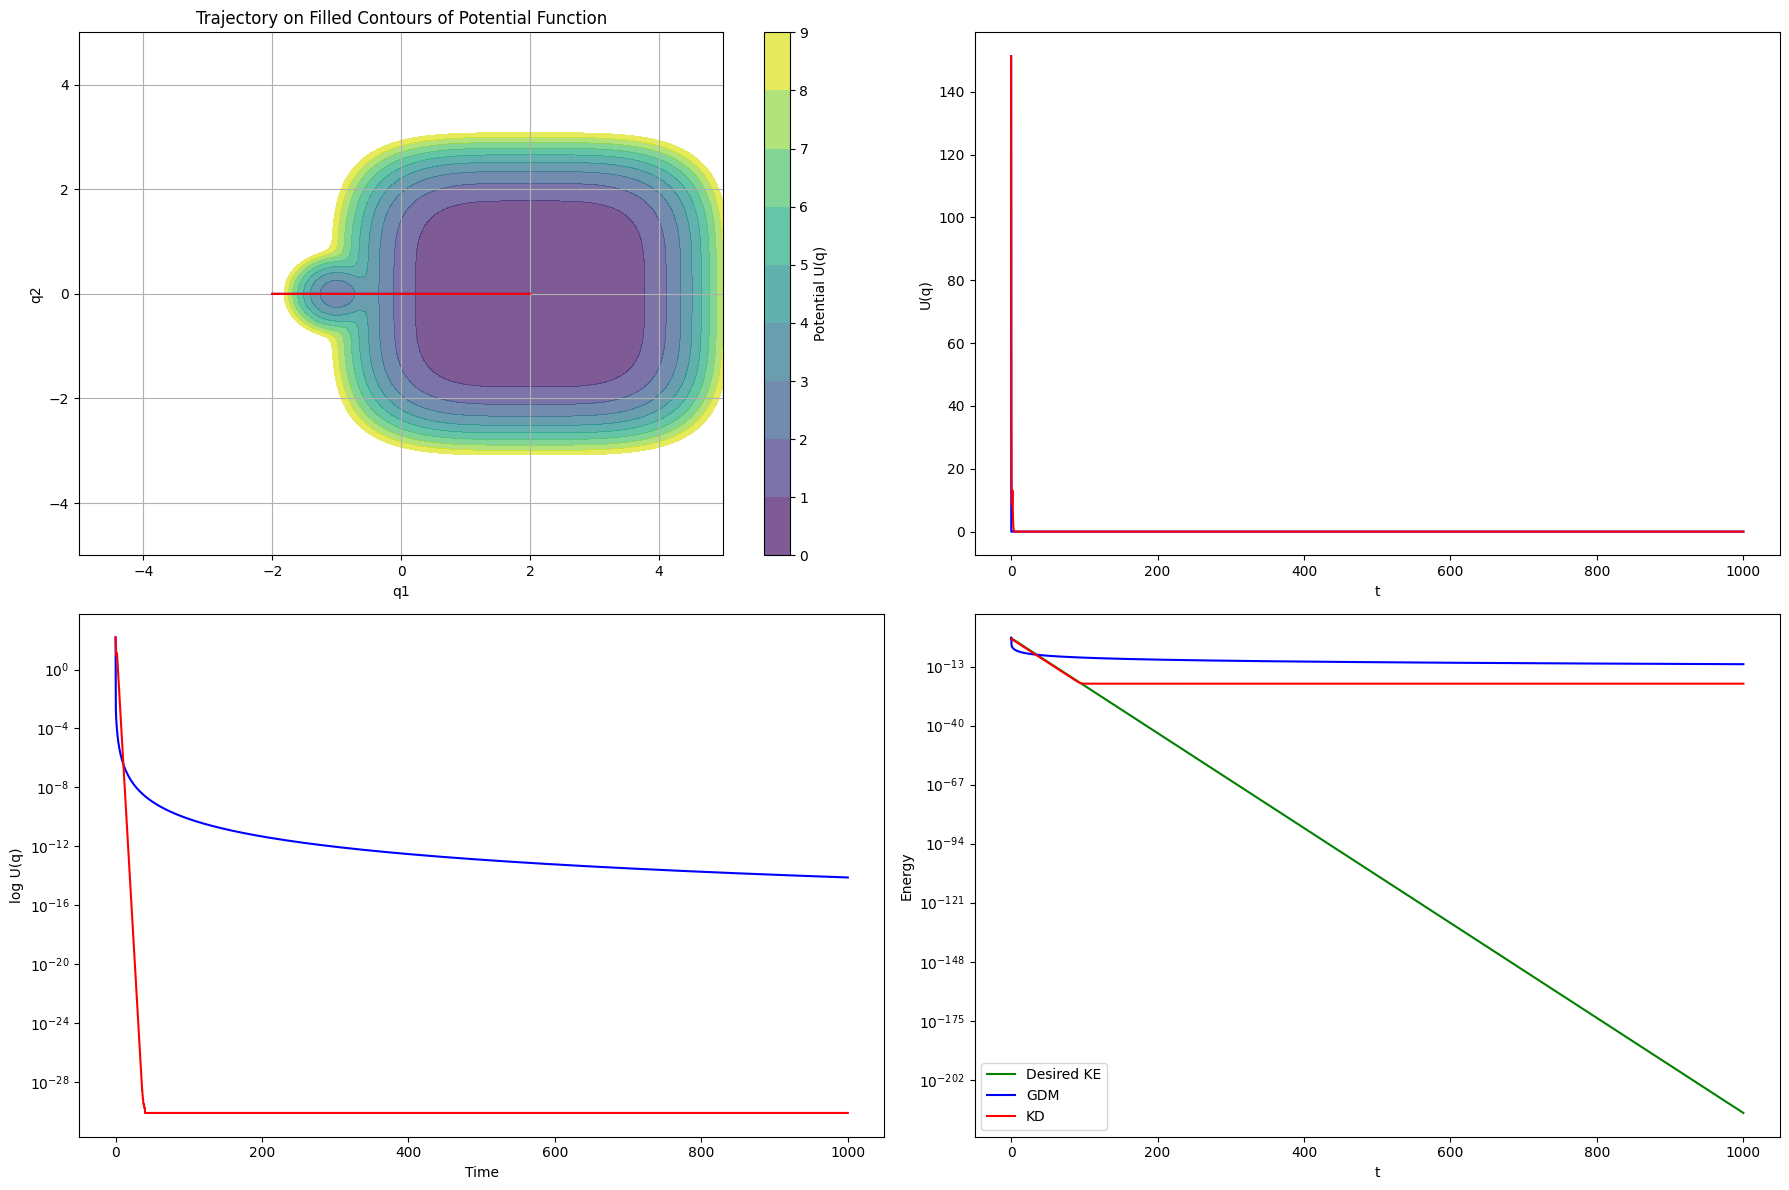

In [134]:
Pars['beta'] = 0.25
T, Q_gd, P_gd, KE_hd, PE_gd = gd_traj(q0, p0, h, Ns, Pars, Model)
#plot_diagnostics_2D(Q_gd,P_gd,T/h,PE_gd, potential_lambda,Pars,lim=5)
plot_compare(Q_gd, Q, P_gd, P, T, PE_gd, PE, potential_lambda, 1, Pars['gamma'],lim=5)

In [ ]:
x = np.linspace(-2.1, 5, 100)
y = np.linspace(-3.1, 3.1, 100)
potential_lambda = lambda X,Y: -np.log(Pars['coeff'][0]*np.exp(Pars['coeff'][2]*((X-2)**4+Y**4))+ Pars['coeff'][1] * np.exp(Pars['coeff'][3]*((X+1)**2+1*Y**2)))
X, Y = np.meshgrid(x, y)
Z = potential_lambda(X,Y)
Q_Z = potential_lambda(Q[:, 0], Q[:, 1])
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none', zorder=1)
contour = ax.contour(X, Y, Z, levels=50, cmap='viridis', offset=np.min(Z), zorder=2)
ax.plot(Q[:, 0], Q[:, 1], Q_Z, lw=3, color='black', label='KD', zorder=3)
ax.plot(Q_gd[:, 0], Q_gd[:, 1], potential_lambda(Q_gd[:, 0], Q_gd[:, 1]), lw=3, color='red', label='PHB', zorder=3)
ax.scatter(Q[0, 0], Q[0, 1], Q_Z[0], color='blue', label='Start', marker='o', s=100, zorder=4)
ax.scatter(Q[-1, 0], Q[-1, 1], Q_Z[-1], color='blue', label='End', marker='*', s=100, zorder=4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.view_init(elev=40, azim=-40)
ax.set_axis_off()
plt.legend()
plt.show()


## Make a grid of initial conditions for this

# Ackley's function

/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_1462/2275935212.py:87: RuntimeWarning: divide by zero encountered in arctanh
  kappa = np.arctanh(eta)
/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_1462/2275935212.py:89: RuntimeWarning: invalid value encountered in scalar divide
  A = np.cosh(kappa) / np.cosh(alpha * h + kappa)
/var/folders/sx/y6c6vjtn04719m5bcb52hk3r0000gn/T/ipykernel_1462/2275935212.py:90: RuntimeWarning: invalid value encountered in scalar subtract
  B = (np.sinh(alpha * h + kappa) - np.sinh(kappa)) / (alpha * np.cosh(alpha * h + kappa))


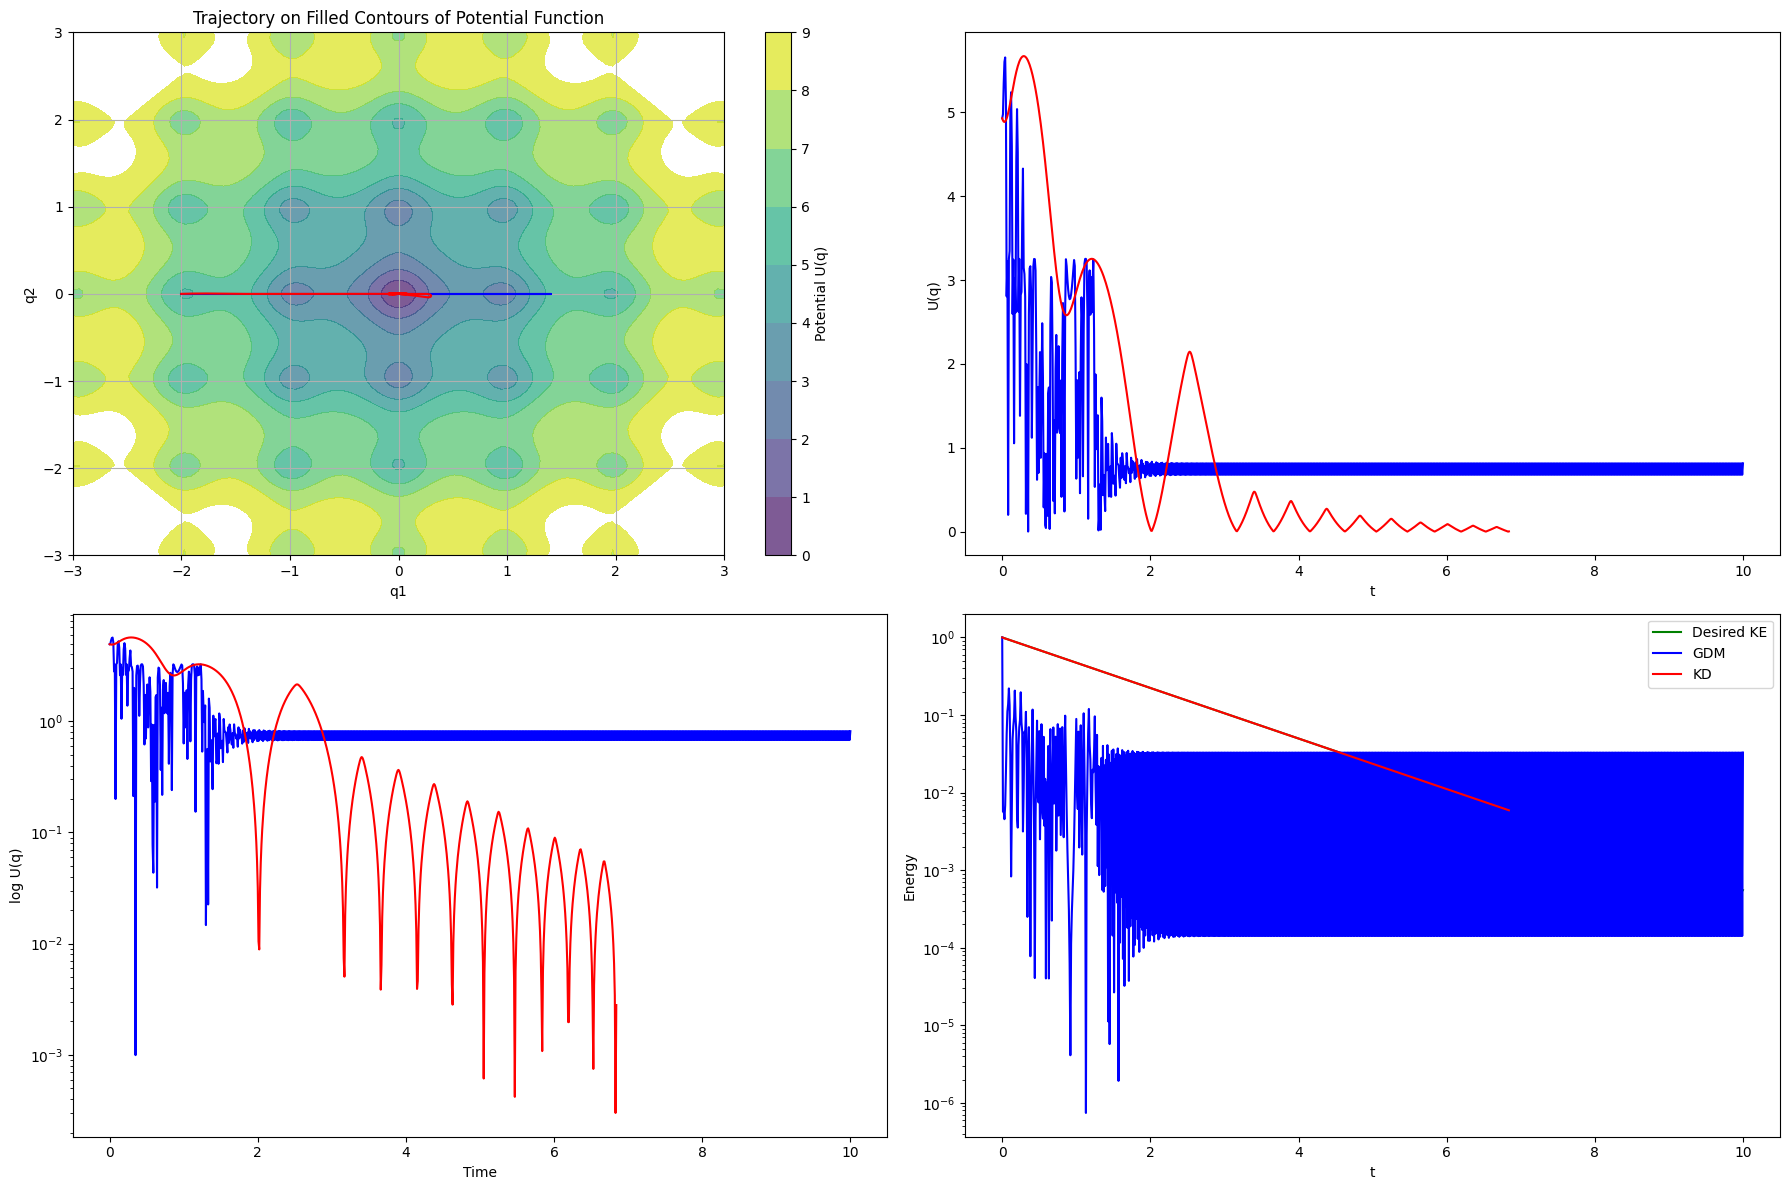

In [3]:
Pars = {}
Model = {}
Pars['gamma'] = .75
c0 = 1
decay_exp = {
    'c': lambda t, P: c0 * np.exp(-P['gamma'] * t),
    'cp': lambda t, P: -P['gamma'] * c0 * np.exp(-P['gamma'] * t),
    'csqrt': lambda t, P: np.sqrt(c0 * np.exp(-P['gamma'] * t))
}
Pars['decay'] = decay_exp

# Ackley function
U = lambda x, P: -20 * np.exp(-0.2 * np.sqrt(0.5 * np.sum(x**2))) - \
                 np.exp(0.5 * np.sum(np.cos(2 * np.pi * x))) + np.e + 20

potential_lambda = lambda X, Y: -20 * np.exp(-0.2 * np.sqrt(0.5 * (X**2 + Y**2))) - np.exp(0.5 * (np.cos(2 * np.pi * X) + np.cos(2 * np.pi * Y))) + np.e + 20
# Negative gradient of Ackley function
F = lambda x, P: np.array([
    20 * np.exp(-0.2 * np.sqrt(0.5 * np.sum(x**2))) * (-x[i] / (np.sqrt(2 * np.sum(x**2)))) +
    np.exp(0.5 * np.sum(np.cos(2 * np.pi * x))) * (-np.sin(2 * np.pi * x[i]) * 2 * np.pi)
    for i in range(len(x))
])


Model['U'] = U
Model['F'] = F

q0 = np.array([-2, 0.])
p0 = F(q0, Pars) + np.random.randn(2)
p0 = (p0 / np.linalg.norm(p0)) * np.sqrt(2 * c0)
h = 0.01
Ns = 1000
T, Q, P, KE, PE = kd_traj(q0, p0, h, Ns, Pars, Model, tol = 1e-5)
Pars['beta'] = 0.9
T, Q_gd, P_gd, KE_hd, PE_gd = gd_traj(q0, p0, h, Ns, Pars, Model)
plot_compare(Q_gd, Q, P_gd, P, T, PE_gd, PE, potential_lambda, 1, Pars['gamma'],lim=3)
#plot_diagnostics_2D(Q_gd,P_gd,T/h,PE_gd, potential_lambda,Pars,lim=5)

## Make a grid

# Matyas Function

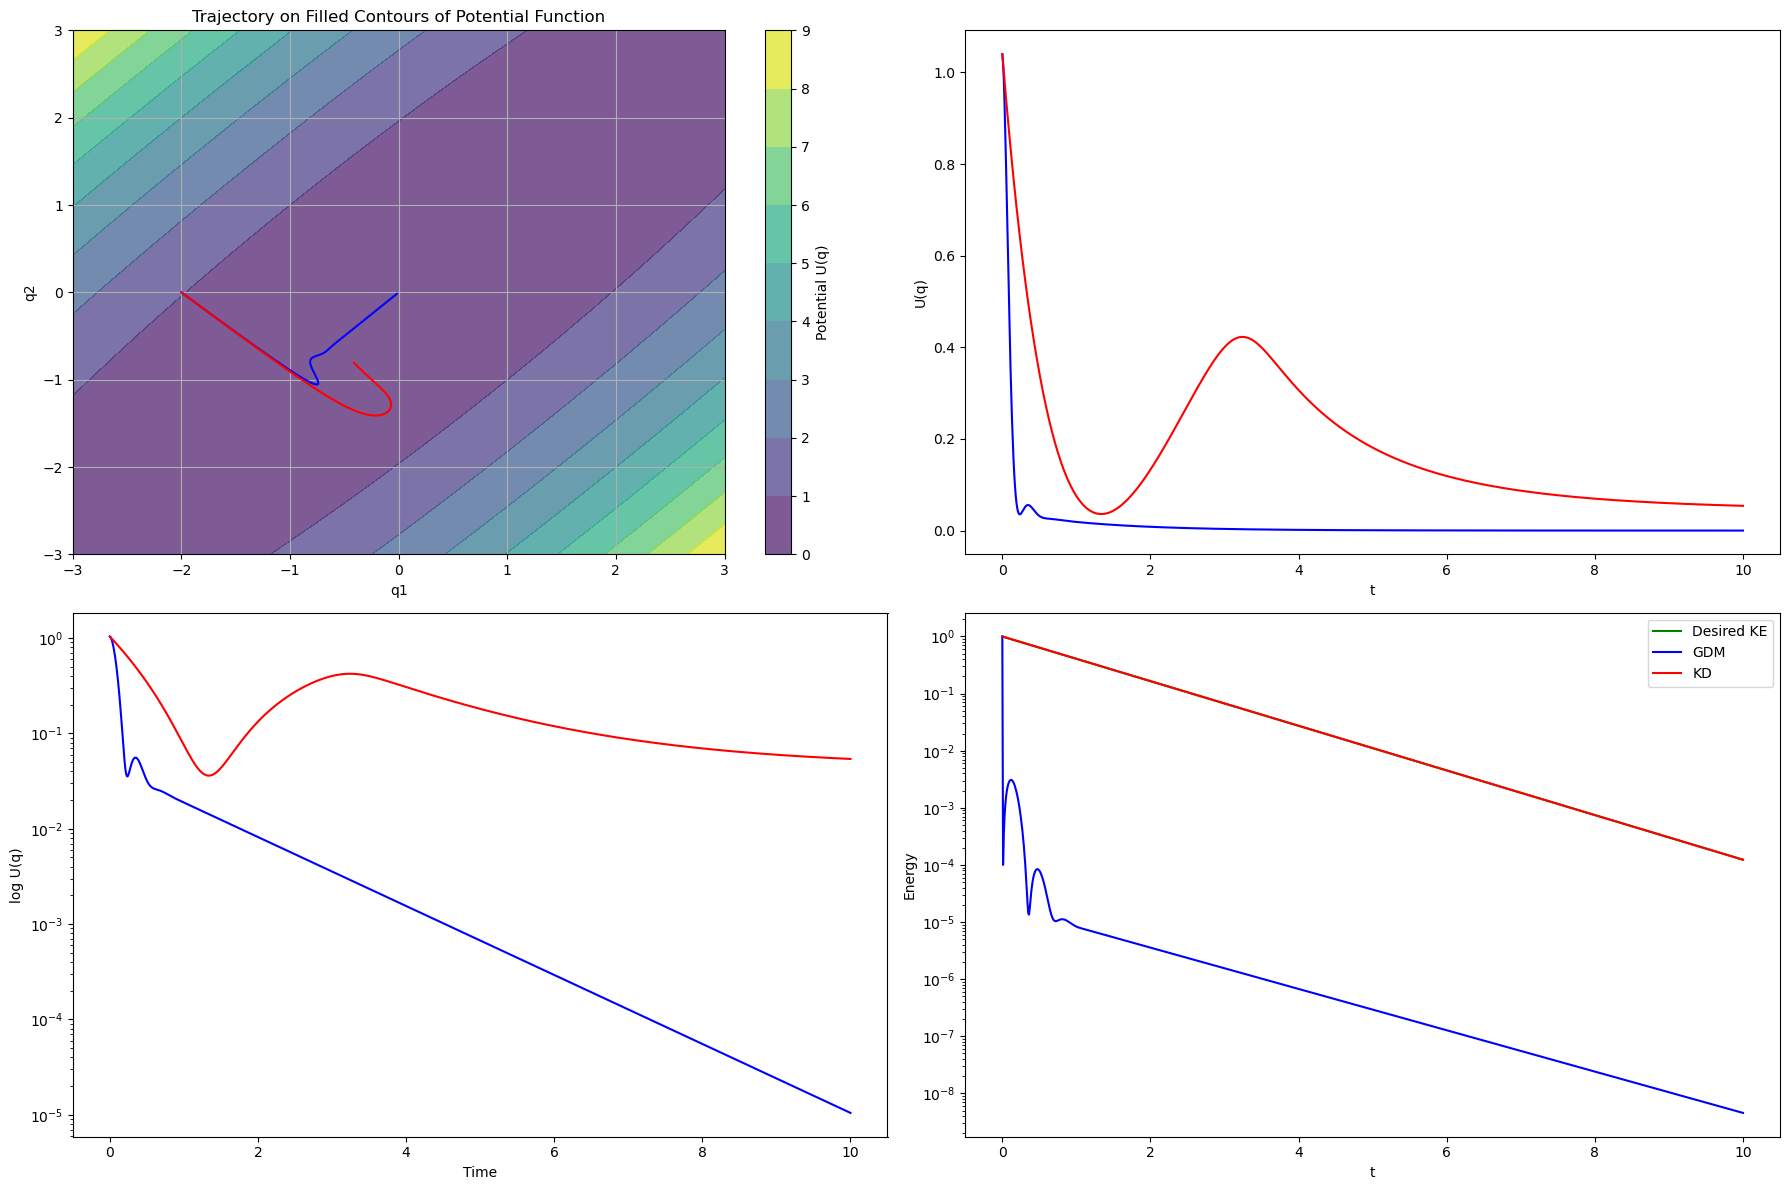

In [14]:
# Define Parameters
Pars = {}
Model = {}
Pars['gamma'] = .9  # Friction term
c0 = 1

# Decay function for kinetic energy
decay_exp = {
    'c': lambda t, P: c0 * np.exp(-P['gamma'] * t),
    'cp': lambda t, P: -P['gamma'] * c0 * np.exp(-P['gamma'] * t),
    'csqrt': lambda t, P: np.sqrt(c0 * np.exp(-P['gamma'] * t))
}
Pars['decay'] = decay_exp

# Matyas function
U = lambda x, P: 0.26 * np.sum(x**2) - 0.48 * np.prod(x)

# Potential function for contour plots
potential_lambda = lambda X, Y: 0.26 * (X**2 + Y**2) - 0.48 * X * Y

# Negative gradient (force function)
F = lambda x, P: np.array([
    - (0.52 * x[0] - 0.48 * x[1]), 
    - (0.52 * x[1] - 0.48 * x[0])
])

Model['U'] = U
Model['F'] = F

# Initial conditions
q0 = np.array([-2, 0.])
p0 = F(q0, Pars) #+ np.random.randn(2)  # Add random perturbation
p0 = (p0 / np.linalg.norm(p0)) * np.sqrt(2 * c0)  # Normalize momentum

# Time step and iterations
h = 0.01
Ns = 1000  # Number of steps

# Compute kinetic descent trajectory
T, Q, P, KE, PE = kd_traj(q0, p0, h, Ns, Pars, Model, tol=1e-8)
Pars['beta'] = 0.9
T, Q_gd, P_gd, KE_hd, PE_gd = gd_traj(q0, p0, h, Ns, Pars, Model)
# Plot results
plot_compare(Q_gd, Q, P_gd, P, T, PE_gd, PE, potential_lambda, 1, Pars['gamma'],lim=3)

# Himmelblau's Function

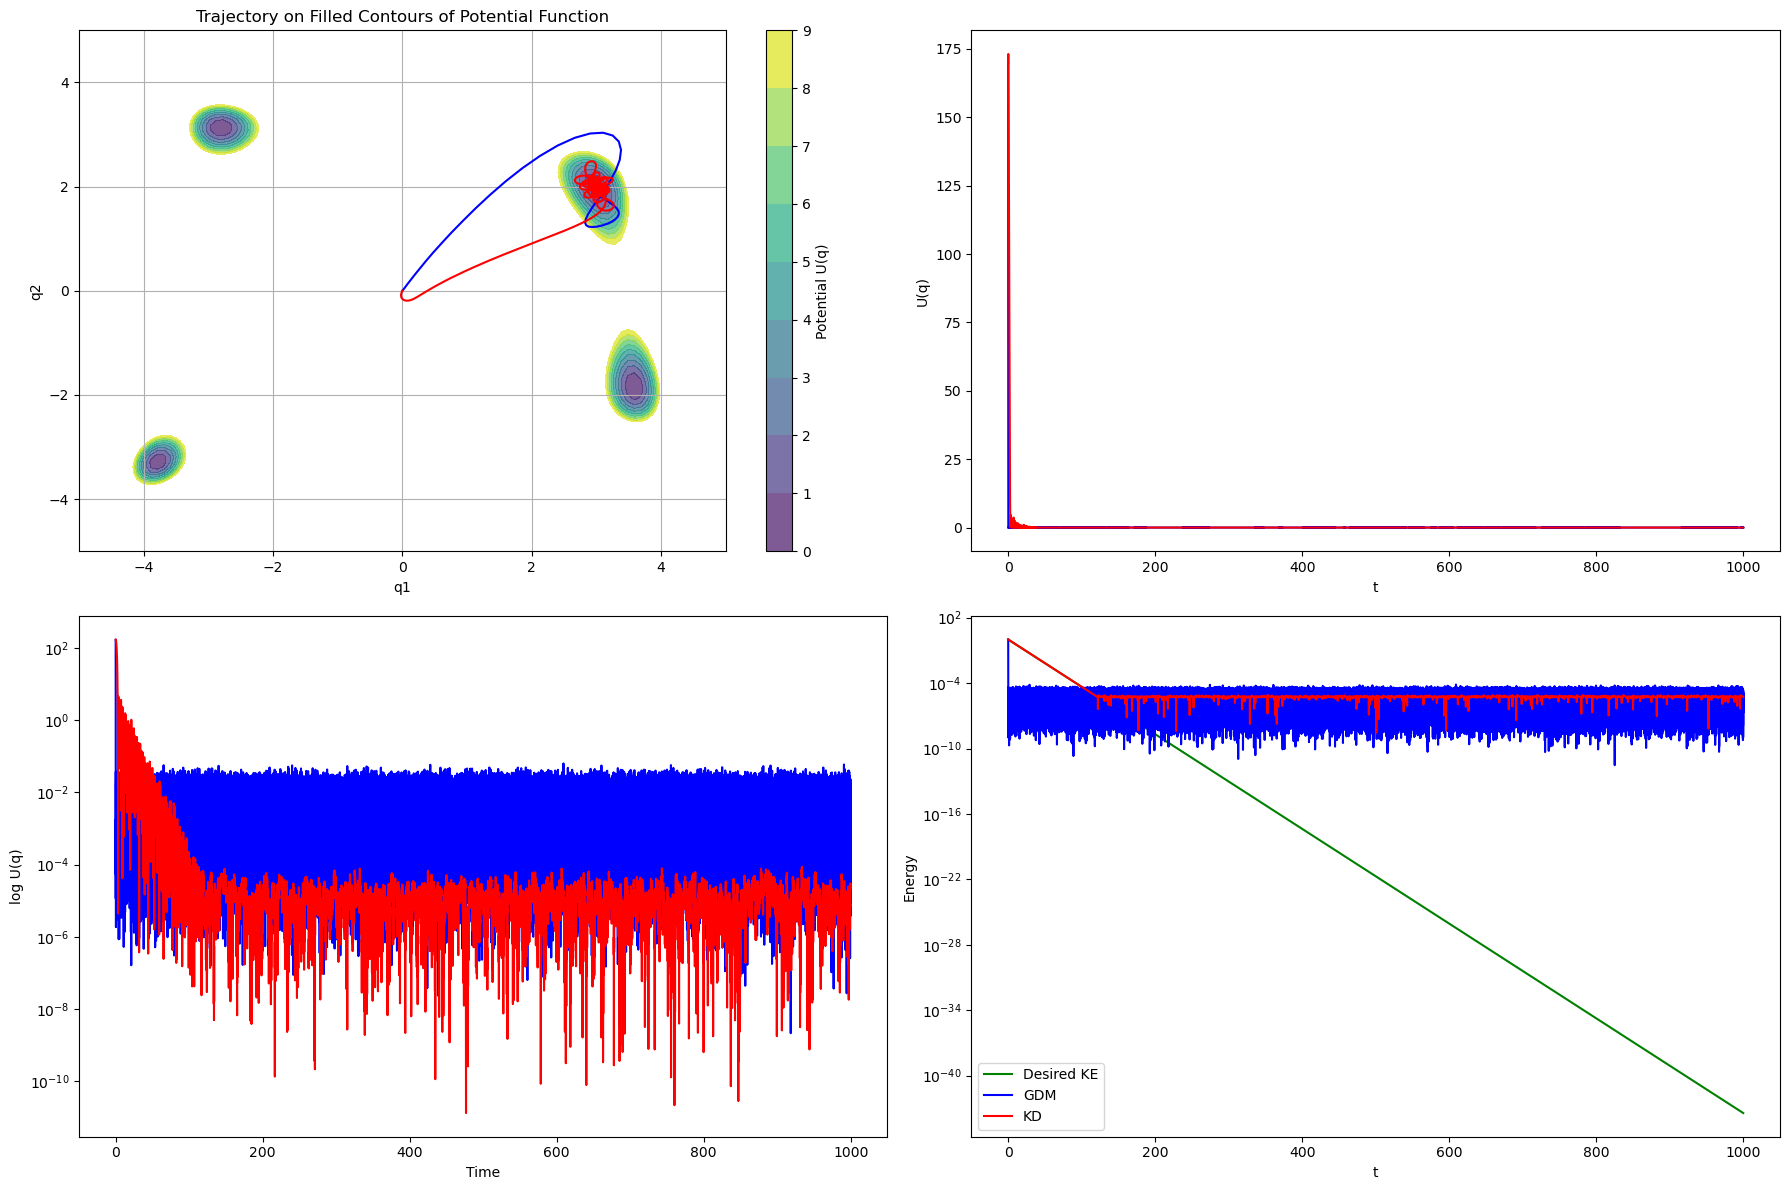

In [30]:
# Define Parameters
Pars = {}
Model = {}
Pars['gamma'] = 0.1 # Friction term
c0 = 1

# Decay function for kinetic energy
decay_exp = {
    'c': lambda t, P: c0 * np.exp(-P['gamma'] * t),
    'cp': lambda t, P: -P['gamma'] * c0 * np.exp(-P['gamma'] * t),
    'csqrt': lambda t, P: np.sqrt(c0 * np.exp(-P['gamma'] * t))
}
Pars['decay'] = decay_exp

# Himmelblau function
U = lambda x, P: (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

# Potential function for contour plots
potential_lambda = lambda X, Y: (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2

# Negative gradient (force function)
F = lambda x, P: np.array([
    - 2 * (x[0]**2 + x[1] - 11) * (2 * x[0]) - 2 * (x[0] + x[1]**2 - 7),
    - 2 * (x[0]**2 + x[1] - 11) - 2 * (x[0] + x[1]**2 - 7) * (2 * x[1])
]) + 1 * np.random.randn(2)

Model['U'] = U
Model['F'] = F 

# Initial conditions
q0 = np.array([-0, 0.])  # Start near one of the known minima
p0 = np.random.randn(2)#F(q0, Pars)  # Initial momentum
p0 = (p0 / np.linalg.norm(p0)) * np.sqrt(2 * c0)  # Normalize momentum

# Time step and iterations
h = 0.001
Ns = 1000000  # Number of steps

# Compute kinetic descent trajectory
T, Q, P, KE, PE = kd_traj(q0, p0, h, Ns, Pars, Model, tol=1e-5)
Pars['beta'] = 0.1
T, Q_gd, P_gd, KE_hd, PE_gd = gd_traj(q0, p0, h, Ns, Pars, Model)
# Plot results
plot_compare(Q_gd, Q, P_gd, P, T, PE_gd, PE, potential_lambda, 1, Pars['gamma'],lim=5)
